# Morphological Analysis of Latin

In [1]:
import numpy as np
import tensorflow as tf
import keras.backend as K

config = tf.ConfigProto(intra_op_parallelism_threads=8, 
                        inter_op_parallelism_threads=8,
                        allow_soft_placement=True, 
                        device_count = {'CPU': 1})
session = tf.Session(config=config)
K.set_session(session)

def load_corpus(filename, tagged=True):
    with open(filename, "r") as f:
        sentences = []
        words = {}
        for line in f:
            sentence = []
            pairs = line.rstrip('\n').split(' ')
            for pair in pairs:
                if pair != '':
                    if tagged == True:
                        word, tag = pair.split('/')
                        sentence.append((word, tag))
                        words[(word, tag)] = words.get((word, tag), 0) + 1                    
                    else:
                        sentence.append(pair)
                        words[pair] = words.get(pair, 0) + 1
            sentences.append(sentence)


        return words, sentences

Using TensorFlow backend.


In [2]:
words, sents = load_corpus('../corpora/latin/latin.all_features')

In [3]:
def build_alphabet(words):
    alphabet = {}
    max_word_len = 0
    
    for word in words:
        max_word_len = max(len(word), max_word_len)
        for letter in word:
            alphabet[letter] = alphabet.get(letter, 0) + 1
            
    return list(alphabet.keys()), max_word_len

In [4]:
alpha, max_word_len = build_alphabet([word for word,_ in words.keys()])
max_word_len

36

In [5]:
lengths = np.sort([len(sent) for sent in sents])
length, count = np.unique(lengths, return_counts=True)
print(dict(zip(length, count)))

{1: 281, 2: 740, 3: 1369, 4: 1455, 5: 1515, 6: 1563, 7: 1333, 8: 1263, 9: 1133, 10: 1034, 11: 890, 12: 813, 13: 678, 14: 625, 15: 505, 16: 499, 17: 437, 18: 346, 19: 300, 20: 259, 21: 237, 22: 232, 23: 195, 24: 155, 25: 154, 26: 144, 27: 119, 28: 131, 29: 105, 30: 90, 31: 74, 32: 74, 33: 62, 34: 51, 35: 49, 36: 33, 37: 40, 38: 37, 39: 39, 40: 30, 41: 31, 42: 26, 43: 19, 44: 23, 45: 23, 46: 25, 47: 21, 48: 16, 49: 15, 50: 16, 51: 6, 52: 9, 53: 6, 54: 9, 55: 4, 56: 2, 57: 4, 58: 3, 59: 3, 60: 6, 61: 5, 62: 6, 63: 5, 64: 5, 65: 2, 66: 4, 67: 1, 68: 5, 69: 3, 70: 4, 72: 3, 73: 2, 74: 3, 75: 1, 76: 2, 77: 1, 80: 1, 81: 2, 82: 2, 85: 3, 88: 1, 90: 3, 91: 1, 100: 1, 144: 1, 163: 1, 237: 1}


In [6]:
max_word_len = 16
max_sent_len = 50

In [7]:
from keras.utils.np_utils import to_categorical

feature_names = ['pos', 'person', 'number', 'tense', 'mood', 'voice', 'gender', 'case', 'degree', 'strength', 'inflection']

def indexify(string_list):
    vocab = list(set(string_list))
    return np.asarray([vocab.index(elem)+1 for elem in string_list]), vocab

def convert_morphology(tagged_words):
    slicers = [(0,2),2,3,4,5,6,7,8,9,10,11]
    feature_tags = [[] for _ in slicers]
    
    for _, tag in tagged_words:
        for i, slicer in enumerate(slicers):
            start, end = slicer if type(slicer) == tuple else (slicer, slicer + 1)
            feature_tags[i].append(tag[start:end])
        
    vectors = []
    label_sets = []
    indices = []
    for feature in feature_tags:
        idx, labels = indexify(feature)
        label_sets.append(labels)
        indices.append(idx)
        vectors.append(to_categorical(idx))
        
    return vectors, label_sets, indices

In [8]:
def select_letter_indices(word, alphabet, max_word_len):
    v = np.zeros((max_word_len))
    
    for i in range(min(len(word), max_word_len)):
        v[i] = alphabet.index(word[i]) + 1 if word[i] in alphabet else 0
        
    return v
    
def create_char_dataset(tagged_words, sentences, alphabet, max_sent_len, max_word_len):
    num_sentences = len(sentences)
    X = np.zeros((num_sentences, max_sent_len, max_word_len), dtype='int32')
    
    tagged_tokens = []
    for i, sent in enumerate(sentences):
        sent_len = len(sent)
        for j, (word, tag) in enumerate(sent):
            if j >= max_sent_len:
                break
            tagged_tokens.append((word, tag))
            X[i, j, :] = select_letter_indices(word, alphabet, max_word_len)
        
    features, labels, _ = convert_morphology(tagged_tokens)
    
    Y = [np.zeros((num_sentences, max_sent_len, F.shape[1])) for F in features]
    i = 0
    for j, sent in enumerate(sentences):
        for k in range(min(max_sent_len, len(sent))):
            for f in range(len(features)):
                Y[f][j, k, :] = features[f][i]
            i += 1

    return X, Y, labels, tagged_tokens

In [9]:
X, Y, labels, _ = create_char_dataset(words, sents, alpha, max_sent_len, max_word_len)

In [10]:
labels

[['Du',
  'Dq',
  'Ma',
  'Mo',
  'G-',
  'A-',
  'C-',
  'Pk',
  'Pp',
  'Pc',
  'Ne',
  'V-',
  'F-',
  'Px',
  'Pi',
  'R-',
  'Pr',
  'Pd',
  'I-',
  'Df',
  'Ps',
  'Nb',
  'Pt'],
 ['2', '1', '-', '3'],
 ['s', '-', 'p'],
 ['r', 'i', 'l', '-', 't', 'f', 'p'],
 ['s', 'g', 'm', 'i', 'n', '-', 'd', 'u', 'p'],
 ['a', '-', 'p'],
 ['m', 'o', 'r', 'n', 'q', '-', 'f', 'p'],
 ['v', 'g', 'n', '-', 'd', 'a', 'b'],
 ['s', 'c', '-', 'p'],
 ['-'],
 ['i', 'n']]

In [11]:
X.shape, Y[0].shape

((19425, 50, 16), (19425, 50, 24))

In [12]:
X_test, Y_test = X[17905:], [y[17905:] for y in Y]
X = X[:17905]
Y = [y[:17905] for y in Y]

In [13]:
def load_vocab(filename):
    vocab = {}
    rev_vocab = {}
    
    with open(filename, 'r') as f:
        for pair in f:
            idx, word = pair.split()
            vocab[word] = int(idx)
            rev_vocab[int(idx)] = word
            
    return vocab, rev_vocab

In [14]:
vocab, rev_vocab = load_vocab('../models/latin/latin_types.txt')

In [15]:
len(vocab)

259999

In [16]:
import pickle

def load_vectors(filename):
    with open(filename, 'rb') as f:
        vectors = pickle.load(f)
        
    vectors = np.concatenate([np.zeros((1,300)),vectors],axis=0)
    norm_vectors = np.divide(vectors, np.linalg.norm(vectors, axis=-1, keepdims=True))
    norm_vectors[0] = 0
    
    return norm_vectors

In [17]:
vectors = load_vectors('../models/latin/latin_vectors.bin')

/home/jds/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [18]:
def create_word_dataset(sentences, vocab, max_sent_len):
    X = np.zeros((len(sentences), max_sent_len))
    for i, sent in enumerate(sentences):
        for j, (word, _) in enumerate(sent):
            if j == max_sent_len:
                break
            X[i,j] = vocab.get(word, 0)
            
    return X

In [19]:
X2 = create_word_dataset(sents, vocab, max_sent_len)
X2_train = X2[:17905]
X2_test = X2[17905:]
X2_test.shape
X2.shape

(19425, 50)

In [20]:
from keras import layers, Input
from keras.models import Model
from keras import regularizers
import keras.backend as K

def make_char_word_rnn_model(
    word_vectors,
    alphabet_size, 
    char_vector_width, 
    max_sent_len,
    max_word_len, 
    char_lstm_size,
    word_lstm_size,
    morpho_sizes,
    morpho_names,
    dense_size):
    
    
    # The Char portion
    # sub-word features
    char_embed = layers.Embedding(alphabet_size + 1,
                             char_vector_width,
                             input_length = max_word_len,
                             trainable = True,
                             mask_zero = True)  
    
    # encode the input
    char_input = Input(shape=(max_sent_len, max_word_len, ), dtype='float32')
    vectors = layers.TimeDistributed(char_embed)(char_input)
    
    # run word-level RNNs over the letters
    word_rnn = layers.Bidirectional(layers.GRU(char_lstm_size, activation='tanh', 
                                                dropout=0.2, recurrent_dropout=0.2))
    char_vectors = layers.TimeDistributed(word_rnn)(vectors)
   
    # The Word portion
    # word vectors
    word_embed = layers.Embedding(word_vectors.shape[0],
                                  word_vectors.shape[1],
                                  input_length=max_sent_len,
                                  weights=[word_vectors],
                                  trainable = False,
                                  mask_zero = True)
    
    word_input = Input(shape=(max_sent_len,), dtype='float32')
    word_vectors = word_embed(word_input)
    
    char_word_vectors = layers.concatenate([char_vectors, word_vectors], axis=-1)
    
    word_lstm = layers.Bidirectional(layers.LSTM(word_lstm_size, return_sequences=True, 
                                                 name='word_encoder',
                                                 activation='tanh',
                                                 kernel_regularizer=regularizers.l2(0.01),
                                                 activity_regularizer=regularizers.l2(0.01),
                                                 dropout=0.4, recurrent_dropout=0.4))(char_word_vectors)
    
    
    # push through dense layers
    out = layers.Dense(dense_size, activation='relu')(word_lstm)
    out = layers.Dropout(rate=0.2)(out)
    out = layers.Dense(dense_size, activation='relu')(out)
    out = layers.Dropout(rate=0.2)(out)
    out = layers.Dense(dense_size, activation='relu')(out)
    out = layers.Dropout(rate=0.2)(out)
    
    # generate the output via softmax layers
    outputs = [layers.Dense(morpho_size, activation='softmax', name=morpho_names[i])(out) 
               for i, morpho_size in enumerate(morpho_sizes)]

    model = Model([char_input, word_input], outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    
    return model

In [21]:
m1 = make_char_word_rnn_model(vectors, len(alpha), 
                              60, max_sent_len, max_word_len,
                              100, 100,
                              [y.shape[2] for y in Y],
                              feature_names,
                              200)
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 16)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 50, 16, 60)   9660        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 50, 200)      96600       time_distributed_1[0][0]         
__________________________________________________________________________________________________
embedding_

In [22]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import keras


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.accs = {}
        self.val_accs = {}
        for f in feature_names:
            self.accs[f] = []
            self.val_accs[f] = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        for f in feature_names:
            self.accs[f].append(logs.get(f + '_acc'))
            self.val_accs[f].append(logs.get('val_' + f + '_acc'))
        self.i += 1
        
        clear_output(wait=True)
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(20, 10))
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        
        for f in feature_names:
            ax2.plot(self.x, self.accs[f], label=(f + "_acc"))
            ax3.plot(self.x, self.val_accs[f], label="val_" + f + "_acc")
            
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show();
        
        for f in feature_names:
            print(f +  " best:", np.round(np.max(self.val_accs[f]), 3), "last:", np.round(self.val_accs[f][-1], 3))
        
plot_losses = PlotLosses()

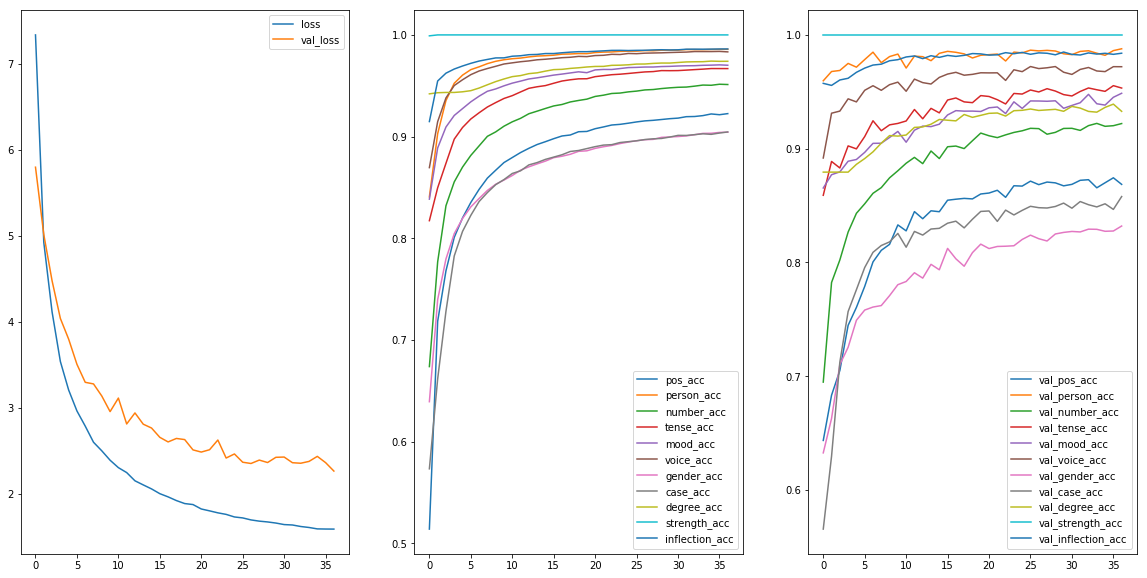

pos best: 0.874 last: 0.869
person best: 0.988 last: 0.988
number best: 0.922 last: 0.922
tense best: 0.955 last: 0.953
mood best: 0.949 last: 0.949
voice best: 0.972 last: 0.972
gender best: 0.832 last: 0.832
case best: 0.858 last: 0.858
degree best: 0.939 last: 0.933
strength best: 1.0 last: 1.0
inflection best: 0.985 last: 0.984
Epoch 38/100
 4800/17905 [=======>......................] - ETA: 3:50 - loss: 1.5725 - pos_loss: 0.2422 - person_loss: 0.0408 - number_loss: 0.1248 - tense_loss: 0.0926 - mood_loss: 0.0775 - voice_loss: 0.0482 - gender_loss: 0.2655 - case_loss: 0.2514 - degree_loss: 0.0730 - strength_loss: 1.2108e-07 - inflection_loss: 0.0366 - pos_acc: 0.9212 - person_acc: 0.9866 - number_acc: 0.9519 - tense_acc: 0.9665 - mood_acc: 0.9714 - voice_acc: 0.9841 - gender_acc: 0.9067 - case_acc: 0.9053 - degree_acc: 0.9743 - strength_acc: 1.0000 - inflection_acc: 0.9853

In [ ]:
idx = list(range(len(X)))
np.random.shuffle(idx)
history = m1.fit([X[idx], X2_train[idx]], [y[idx] for y in Y],
                 batch_size=16, epochs=100,
                 callbacks=[plot_losses],
                 validation_data=([X_test, X2_test], [y for y in Y_test]))

## Results

Let's evaluate the model against the test set, the same that was used in evaluating the Perceptron tagger above.

In [41]:
dict(zip(feature_names, np.round(m1.evaluate([X_test, X2_test], [y for y in  Y_test], batch_size=256)[-11:], 3)))

110/110 [==============================] - 1s 8ms/step


{'case': 0.87,
 'degree': 0.941,
 'gender': 0.852,
 'inflection': 0.958,
 'mood': 0.972,
 'number': 0.907,
 'person': 0.986,
 'pos': 0.914,
 'strength': 0.955,
 'tense': 0.983,
 'voice': 1.0}

Comparing this result to the Perceptron tagger above, we see that the Word+Char model improves on NLTK's AveragedPerceptron across all features, and especially so for the POS tagging task.  

The POS accuracy of 0.918 puts the Word+Char in the range of the Germanic taggers tested by Horsmann and Zesch, though somewhat on the lower end.

| Feature | Perceptron Tagger | Word+Char LSTM | Diff |
----------|-------------------|----------------|------|
|  POS | 0.840 | 0.914 | + 7.4% |
| Person | 0.956 | 0.979 | + 2.3% |
| Number | 0.827 | 0.91 | + 9.3% |
| Tense | 0.960 | 0.979 | + 3.9% |
| Mood | 0.952 | 0.967 | + 1.5% |
| Gender | 0.798 | 0.858 | + 6.0% |
| Case | 0.814 | 0.874 | + 6.0 % |
| Degree | 0.907 | 0.935 | + 2.8% |
| Strength | 0.927 | 0.954 | + 2.7% |
| Inflection | 0.931 | 0.965 | + 3.4% |

### Error Analysis

In [42]:
import xml.etree.ElementTree as ET

def extract_labels(labelsXML):
    root = ET.fromstring(labelsXML)

    labels = {}

    for parts_of_speech in root.iter('parts-of-speech'):
        labels['pos'] = {}

        for value in parts_of_speech.iter('value'):
            tag = value.attrib['tag']
            label = value.attrib['summary']
            labels['pos'][tag] = label

    for field in root.iter('field'):
        feature = field.attrib['tag']
        labels[feature] = {}
        labels[feature]['-'] = 'none'

        for value in field.iter('value'):
            tag = value.attrib['tag']
            label = value.attrib['summary']
            labels[feature][tag] = label
            
    return labels

In [43]:
labelsXML = '''
<tags>
<parts-of-speech>
      <value tag="A-" summary="adjective"/>
      <value tag="Df" summary="adverb"/>
      <value tag="S-" summary="article"/>
      <value tag="Ma" summary="cardinal numeral"/>
      <value tag="Nb" summary="common noun"/>
      <value tag="C-" summary="conjunction"/>
      <value tag="Pd" summary="demonstrative pronoun"/>
      <value tag="F-" summary="foreign word"/>
      <value tag="Px" summary="indefinite pronoun"/>
      <value tag="N-" summary="infinitive marker"/>
      <value tag="I-" summary="interjection"/>
      <value tag="Du" summary="interrogative adverb"/>
      <value tag="Pi" summary="interrogative pronoun"/>
      <value tag="Mo" summary="ordinal numeral"/>
      <value tag="Pp" summary="personal pronoun"/>
      <value tag="Pk" summary="personal reflexive pronoun"/>
      <value tag="Ps" summary="possessive pronoun"/>
      <value tag="Pt" summary="possessive reflexive pronoun"/>
      <value tag="R-" summary="preposition"/>
      <value tag="Ne" summary="proper noun"/>
      <value tag="Py" summary="quantifier"/>
      <value tag="Pc" summary="reciprocal pronoun"/>
      <value tag="Dq" summary="relative adverb"/>
      <value tag="Pr" summary="relative pronoun"/>
      <value tag="G-" summary="subjunction"/>
      <value tag="V-" summary="verb"/>
      <value tag="X-" summary="unassigned"/>
    </parts-of-speech>
    <morphology>
      <field tag="person">
        <value tag="1" summary="first person"/>
        <value tag="2" summary="second person"/>
        <value tag="3" summary="third person"/>
        <value tag="x" summary="uncertain person"/>
      </field>
      <field tag="number">
        <value tag="s" summary="singular"/>
        <value tag="d" summary="dual"/>
        <value tag="p" summary="plural"/>
        <value tag="x" summary="uncertain number"/>
      </field>
      <field tag="tense">
        <value tag="p" summary="present"/>
        <value tag="i" summary="imperfect"/>
        <value tag="r" summary="perfect"/>
        <value tag="s" summary="resultative"/>
        <value tag="a" summary="aorist"/>
        <value tag="u" summary="past"/>
        <value tag="l" summary="pluperfect"/>
        <value tag="f" summary="future"/>
        <value tag="t" summary="future perfect"/>
        <value tag="x" summary="uncertain tense"/>
      </field>
      <field tag="mood">
        <value tag="i" summary="indicative"/>
        <value tag="s" summary="subjunctive"/>
        <value tag="m" summary="imperative"/>
        <value tag="o" summary="optative"/>
        <value tag="n" summary="infinitive"/>
        <value tag="p" summary="participle"/>
        <value tag="d" summary="gerund"/>
        <value tag="g" summary="gerundive"/>
        <value tag="u" summary="supine"/>
        <value tag="x" summary="uncertain mood"/>
        <value tag="y" summary="finiteness unspecified"/>
        <value tag="e" summary="indicative or subjunctive"/>
        <value tag="f" summary="indicative or imperative"/>
        <value tag="h" summary="subjunctive or imperative"/>
        <value tag="t" summary="finite"/>
      </field>
      <field tag="voice">
        <value tag="a" summary="active"/>
        <value tag="m" summary="middle"/>
        <value tag="p" summary="passive"/>
        <value tag="e" summary="middle or passive"/>
        <value tag="x" summary="unspecified"/>
      </field>
      <field tag="gender">
        <value tag="m" summary="masculine"/>
        <value tag="f" summary="feminine"/>
        <value tag="n" summary="neuter"/>
        <value tag="p" summary="masculine or feminine"/>
        <value tag="o" summary="masculine or neuter"/>
        <value tag="r" summary="feminine or neuter"/>
        <value tag="q" summary="masculine, feminine or neuter"/>
        <value tag="x" summary="uncertain gender"/>
      </field>
      <field tag="case">
        <value tag="n" summary="nominative"/>
        <value tag="a" summary="accusative"/>
        <value tag="o" summary="oblique"/>
        <value tag="g" summary="genitive"/>
        <value tag="c" summary="genitive or dative"/>
        <value tag="e" summary="accusative or dative"/>
        <value tag="d" summary="dative"/>
        <value tag="b" summary="ablative"/>
        <value tag="i" summary="instrumental"/>
        <value tag="l" summary="locative"/>
        <value tag="v" summary="vocative"/>
        <value tag="x" summary="uncertain case"/>
        <value tag="z" summary="no case"/>
      </field>
      <field tag="degree">
        <value tag="p" summary="positive"/>
        <value tag="c" summary="comparative"/>
        <value tag="s" summary="superlative"/>
        <value tag="x" summary="uncertain degree"/>
        <value tag="z" summary="no degree"/>
      </field>
      <field tag="strength">
        <value tag="w" summary="weak"/>
        <value tag="s" summary="strong"/>
        <value tag="t" summary="weak or strong"/>
      </field>
      <field tag="inflection">
        <value tag="n" summary="non-inflecting"/>
        <value tag="i" summary="inflecting"/>
      </field>
    </morphology>
</tags>
'''

In [44]:
labels_full = extract_labels(labelsXML)
labels_full

{'case': {'-': 'none',
  'a': 'accusative',
  'b': 'ablative',
  'c': 'genitive or dative',
  'd': 'dative',
  'e': 'accusative or dative',
  'g': 'genitive',
  'i': 'instrumental',
  'l': 'locative',
  'n': 'nominative',
  'o': 'oblique',
  'v': 'vocative',
  'x': 'uncertain case',
  'z': 'no case'},
 'degree': {'-': 'none',
  'c': 'comparative',
  'p': 'positive',
  's': 'superlative',
  'x': 'uncertain degree',
  'z': 'no degree'},
 'gender': {'-': 'none',
  'f': 'feminine',
  'm': 'masculine',
  'n': 'neuter',
  'o': 'masculine or neuter',
  'p': 'masculine or feminine',
  'q': 'masculine, feminine or neuter',
  'r': 'feminine or neuter',
  'x': 'uncertain gender'},
 'inflection': {'-': 'none', 'i': 'inflecting', 'n': 'non-inflecting'},
 'mood': {'-': 'none',
  'd': 'gerund',
  'e': 'indicative or subjunctive',
  'f': 'indicative or imperative',
  'g': 'gerundive',
  'h': 'subjunctive or imperative',
  'i': 'indicative',
  'm': 'imperative',
  'n': 'infinitive',
  'o': 'optative',


In [45]:
from nltk.metrics import ConfusionMatrix

predicted = m2.predict([X_test, X2_test])

for i, feature in enumerate(feature_names):
    print('---------------- ', feature, ' ----------------')
    gold = np.ndarray.flatten(np.argmax(Y_test[i], axis=2))
    mask = gold > 0
    pred = np.ndarray.flatten(np.argmax(predicted[i], axis=2))
    
    gold_labels = [labels_full[feature][labels[i][idx-1]] for idx in gold[mask]]
    pred_labels = [labels_full[feature][labels[i][idx-1]] for idx in pred[mask]]
    print(ConfusionMatrix(gold_labels, pred_labels))

ImportError: No module named 'nltk'

A few considerations:

* POS tagging, there is some equivocation between adjectives and nouns, perhaps explained by the observation that in OE adjectives are inflected like nouns for case, gender, number.  Also, because of its relatively free word order, adjectives are not predictable pre- or post-nominal or in predicate position.
* Another issue for POS tagging is the "subjunction" annotation, which the tagger frequently mis-tags as adverbial.  These "subjuction" elements appear to be complementizers, such as *þy* "therefore, because", which might rightly be tagged as adverbial, i.e. merged in A-bar positions.
* Forms annotated as quantifiers are tagged as adjectives by the classifier.  This again is linguistically defensible, as words like *micel* "much, big, a lot" and *manig* "many" are sometimes classed as adjectives (e.g. by [Wiktionary](https://en.wiktionary.org/wiki/manig))
* As for case, there is a predictable equivocation between nominative and accusative case assignment.  This is due to syncretism in OE's case system: nominative and accusative forms overlap in cells of the nominal and adjectival paradigms -- principally in masculine and neuter lemmas --, and since word order is only weakly driven by syntax, disambiguation is difficult.
* The last point might also explain the system's lack of accuracy in distinguishing masculine from neuter forms. Its apparent difficulty in distinguishing feminine from masculine forms likely lies in the phonological heterogeneity of the categories: on encountering a new word, it is difficult to guess at its gender from its form.


## Productification

To be useful in practice, the model parameters must be exported, and the preprocessing routines wrappend in a library.

### Saving and loading


In [46]:
import pickle

def save_morpho_model(path, model, alphabet, feature_names, labels, labels_full):
    model.save(path + "/" + 'morpho_model.h5')
        
    with open(path + '/' + 'morpho_labels.pickle', 'wb') as out:
        pickle.dump(alphabet, out)
        pickle.dump(feature_names, out)
        pickle.dump(labels, out)
        pickle.dump(labels_full, out)
    

In [47]:
save_morpho_model('../models/oe', m1, alpha, feature_names, labels, labels_full)

The loading of the model, the preprocessing and the tagging are best wrapped into a class.

In [51]:
class MorphologicalAnalyzer:
    def __init__(self, path):
        """Loads the model from a saved HDF5 file,
        along with related data structures for taglibs and vocabularies."""
        
        self.model = keras.models.load_model(path + '/' + 'morpho_model.h5')

        with open(path + '/' + 'morpho_labels.pickle', 'rb') as inp:
            self.alphabet = pickle.load(inp)
            self.feature_names = pickle.load(inp)
            self.labels = pickle.load(inp)
            self.labels_full = pickle.load(inp)

        input_layer = self.model.get_layer(index=0)

        self.max_sent_len = input_layer.input_shape[1]
        self.max_word_len = input_layer.input_shape[2]
        
        self.vocab = {}
        with open(path + '/' + 'oe_types.txt', 'r') as f:
            for pair in f:
                idx, word = pair.split()
                self.vocab[word] = int(idx)
                
        
    def _select_letter_indices(self, word):
        """For an input words, returns a vector of indices into the alphabet."""
        v = np.zeros((self.max_word_len))
    
        for i in range(min(len(word), self.max_word_len)):
            v[i] = self.alphabet.index(word[i]) + 1 if word[i] in self.alphabet else 0

        return v
        
    def _characterize(self, sentences):
        """For a list of sentences, returns a tensor of dimension 
        (num sentences, words_per_sentence, letters_per_word)
        of indices into the alphabet."""
        
        X = np.zeros((len(sentences), self.max_sent_len, self.max_word_len), dtype='int32')
    
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j >= self.max_sent_len:
                    break
                X[i, j, :] = self._select_letter_indices(word)

        return X
    
    def _wordize(self, sentences):
        """For a list of sentences, returns a tensor of dimension
        (num_sentences, words_per_sentence)
        of indices into the vocabulary."""
        
        X = np.zeros((len(sentences), self.max_sent_len))
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                X[i,j] = self.vocab[word] + 1 if word in self. vocab else 0

        return X
    
    def preprocess(self, text):
        """Tokenizes a text into sentences and words (list of list of strings) if necessary,
        and maps the tokens to indices into the vocabulary and the alphabet,
        returning a 3D tensor for the characters and 2D tensor for the words."""
        
        if type(text) != list:
            text = text.replace('!','.') 
            text = text.replace(',', ' ')
            sents = [word_tokenize(sent) for sent in sent_tokenize(text)]
        else:
            sents = text
        
        X1 = self._characterize(sents)
        X2 = self._wordize(sents)
        
        return sents, X1, X2
        
    def tag(self, text, batch_size=2049):
        """Takes a text as a string or a list of list of string tokens,
        returning a list of list of tuples (word, feature_bundle),
        where feature_bundle is a dict of feature to feature_value."""
        
        sentences, X1, X2 = self.preprocess(text)
        pred = self.model.predict([X1, X2], verbose=1, batch_size=batch_size)
        tagged_sents = []

        for i, sent in enumerate(sentences):
            tagged_sent = []
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                feature_bundle = {}
                for k, feature_name in enumerate(self.feature_names):
                    idx = np.argmax(pred[k][i,j])-1
                    feature_value = self.labels_full[feature_name][self.labels[k][idx]]
                    if feature_value != 'none':
                        feature_bundle[feature_name] = feature_value
                tagged_sent.append((word, feature_bundle))
            tagged_sents.append(tagged_sent)
        
        return tagged_sents

In [52]:
import time
start_time = time.time()
morph_anal = MorphologicalAnalyzer('../models/oe')
print("---- {0} seconds ----".format(time.time() - start_time))

---- 39.10462212562561 seconds ----


In [36]:
_,everything = load_corpus('../texts/oe/oe_all.txt', tagged=False)

Testing on a laptop with a low-end i5 CPU (Intel© Core™ i5-8250U CPU @ 1.60GHz) with 4 independent cores and 16GB of RAM, we get:

In [37]:
start_time = time.time()
tags = morph_anal.tag(everything, batch_size=256)
print("---- {0} seconds ----".format(time.time() - start_time))

110656/110656 [==============================] - 590s 5ms/step
---- 687.4790625572205 seconds ----


364 seconds for about 1.5MM words translates to a rate of ~ 4,100 words/sec.  This compares with the ~10,000 words/sec for just one feaature (POS) turned in by the Perceptron tagger.  So we lose 2.5x the speed of the individual tagger, but get all features output in return.

In [53]:
_, beowulf = load_corpus('../texts/oe/beowulf.txt', tagged = False)

In [54]:
start_time = time.time()
tags = morph_anal.tag(beowulf, batch_size=512)
print("---- {0} seconds ----".format(time.time() - start_time))

3181/3181 [==============================] - 37s 12ms/step
---- 39.57464933395386 seconds ----


In [55]:
tags[0]

[('Hwæt!',
  {'inflection': 'inflecting',
   'mood': 'imperative',
   'number': 'singular',
   'person': 'second person',
   'pos': 'verb'}),
 ('We',
  {'case': 'nominative',
   'inflection': 'inflecting',
   'number': 'plural',
   'person': 'first person',
   'pos': 'personal pronoun'}),
 ('Gardena', {'inflection': 'inflecting', 'pos': 'verb'}),
 ('in',
  {'degree': 'no degree',
   'inflection': 'non-inflecting',
   'pos': 'preposition'}),
 ('geardagum,',
  {'case': 'dative',
   'gender': 'masculine',
   'inflection': 'inflecting',
   'number': 'plural',
   'pos': 'common noun'})]